In [2]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import torchvision.models as models
import torchvision.utils as utils
import  random
import os
from PIL import Image
import cv2
import shutil

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Available!")
else:
    print("No Cuda! Use CPU")

Cuda Available!


In [4]:
# Load MNIST
def load_MNIST():
    # MNIST Download
    # data preprocess:
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.1307,std=0.3081)]
    )
    # get Dataset
    train_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=True,download=True,transform=transform)
    test_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=False,download=True,transform=transform)
    return train_dataset,test_dataset


In [5]:
# show MNIST
train_dataset,test_dataset = load_MNIST()

train data shape:torch.Size([60000, 28, 28])
test data shape:torch.Size([10000, 28, 28])
train label shape:torch.Size([60000])
test label shape:torch.Size([10000])
single data shape:torch.Size([28, 28])


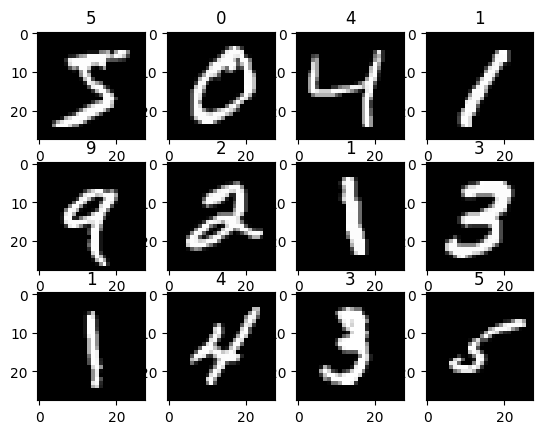

In [6]:
# show MNIST
# MNIST shape:
print("train data shape:{}".format(train_dataset.data.shape))
print("test data shape:{}".format(test_dataset.data.shape))
print("train label shape:{}".format(train_dataset.targets.shape))
print("test label shape:{}".format(test_dataset.targets.shape))
print("single data shape:{}".format(train_dataset.data[0].shape))
# img
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(train_dataset.data[i],cmap='gray')
    plt.title('{}'.format(train_dataset.targets[i]))
plt.show()
plt.close(fig)

## Generate Multiple Digits Image
- 11 digits in an image
- height = 28 width = 28*11
- train:valid = 8:2

In [7]:
# Generate Multiple Digit image:
def Generate_MuiltipleDigit(dataset):
    num = dataset.data.shape[0]
    ori_height = dataset.data.shape[1] # 28
    ori_width = dataset.data.shape[2] # 28
    # generate image with fixed size
    length = 11 # phone number
    X_gen = np.zeros((num,ori_height,length*ori_width))
    Y_gen = np.zeros((num,length),dtype='int64')

    # generate image
    for i in range(num):
        for j in range(length):
            # select number
            idx = random.randint(0,num-1)
            X_gen[i,:,j*ori_width:(j+1)*ori_width] = dataset.data[idx]
            Y_gen[i,j] = dataset.targets[idx]
    
    # convert to Tensor
    X_gen = torch.Tensor(X_gen)
    Y_gen = torch.tensor(Y_gen)


    return X_gen,Y_gen

In [8]:
# Generate Multiple Digit image:
X_train,Y_train = Generate_MuiltipleDigit(train_dataset)
X_test,Y_test = Generate_MuiltipleDigit(test_dataset)

In [9]:
# Show Multiple Digit Image:
def show_MultipleDigit(X,Y):
    print("data shape:{}".format(X.shape))
    print("target shape:{}".format(Y.shape))
    # img
    for i in range(5):
        fig = plt.figure()
        plt.imshow(X[i],cmap='gray')
        plt.title('{}'.format(Y[i]))
        plt.show()
        plt.close(fig)

data shape:torch.Size([60000, 28, 308])
target shape:torch.Size([60000, 11])


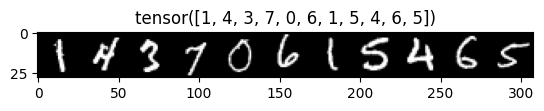

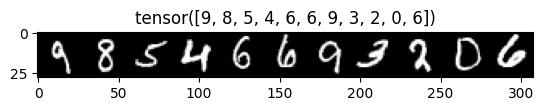

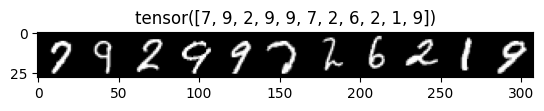

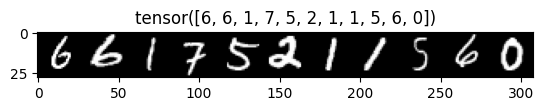

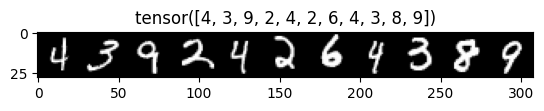

In [10]:
show_MultipleDigit(X_train,Y_train)

data shape:torch.Size([10000, 28, 308])
target shape:torch.Size([10000, 11])


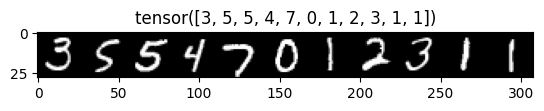

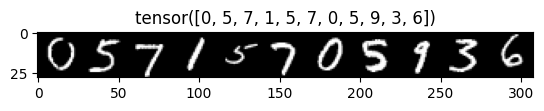

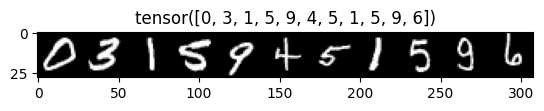

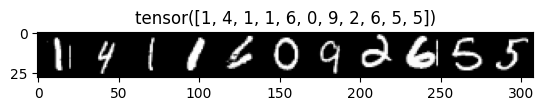

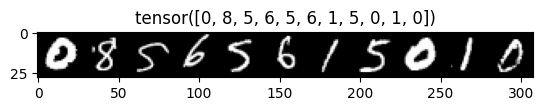

In [11]:
show_MultipleDigit(X_test,Y_test)

In [12]:
# ReWrite Dataset
class MultiMNIST(Dataset):

    def __init__(self,data,target):
        self.data = data
        self.target = target

    def __getitem__(self, index):
        data = self.data[index]
        target = self.target[index]
        return data,target
    
    def __len__(self):
        return len(self.data)


In [13]:
multi_train_dataset = MultiMNIST(X_train,Y_train)
multi_test_dataset = MultiMNIST(X_test,Y_test)

In [14]:
# split training set & validation set:
train_length = int(len(multi_train_dataset)*0.8)
val_length = len(multi_train_dataset)-train_length
multi_train_dataset,multi_valid_dataset = random_split(multi_train_dataset,[train_length,val_length],generator=torch.Generator().manual_seed(0))
multi_train_dataset,multi_valid_dataset = multi_train_dataset.dataset,multi_valid_dataset.dataset

In [15]:
# save as Image:
def save_as_image(dataset,path,path_img):
    if not os.path.exists(path):
        os.mkdir(path)
    if not os.path.exists(path_img):
        os.mkdir(path_img)
    else:
        shutil.rmtree(path_img)
        os.mkdir(path_img)
    # save img
    for i in range(len(dataset)):
        img = Image.fromarray(dataset.data[i].numpy().astype(np.uint8))
        img.save(os.path.join(path_img,str(i)+'.png'))

    # save target
    np.save(os.path.join(path,'label'),dataset.target.numpy())

    print("Save Dataset Successfully!")

In [16]:
train_path = './dataset/MultiDigit/train'
valid_path = './dataset/MultiDigit/valid'
test_path = './dataset/MultiDigit/test'
save_as_image(multi_train_dataset,train_path,train_path+'/img')

Save Dataset Successfully!


## Seperate Single Digit

In [43]:
# load image and target:
def Read_MultipleDigit(path):
    filelist = os.listdir(path+'/img')
    img = cv2.imread(os.path.join(path+'/img',str(0)+'.png'))
    target = np.load(os.path.join(path,'label.npy'))

    data = np.zeros((len(filelist),img.shape[0],img.shape[1],img.shape[2]))
   
    for i in range(len(filelist)):
        data[i] = cv2.imread(os.path.join(path+'/img',str(i)+'.png'))
    return data,target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
d:\InternWorkspace_wsr\torchenv\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


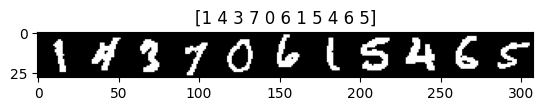

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


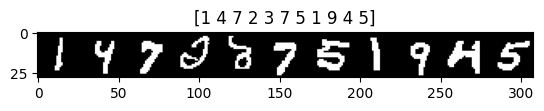

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


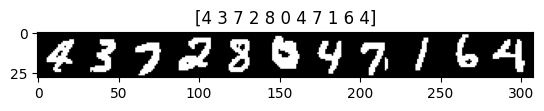

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


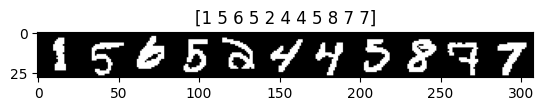

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


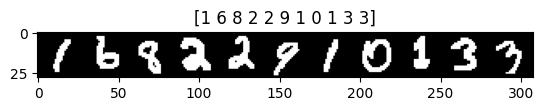

In [44]:
data,target = Read_MultipleDigit('./dataset/MultiDigit/train')
for i in range(5):
    fig = plt.figure()
    plt.imshow(data[i*10],cmap='gray')
    plt.title(target[i*10])
    plt.show()
    plt.close(fig)

In [45]:
def preProccessing(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)
    imgCanny = cv2.Canny(imgBlur, 200, 200)
    imgDial = cv2.dilate(imgCanny, np.ones((5, 5)), iterations=2)  # 膨胀操作
    imgThres = cv2.erode(imgDial, np.ones((5, 5)), iterations=1)  # 腐蚀操作
    return imgThres

In [135]:
# seperate every single digit:
def getContours(img):
    Borderlist = []
    x, y, w, h, xx, yy, ss = 0, 0, 10, 10, 20, 20, 10  # 因为图像大小不能为0
    imgGet = np.array([[], []])  # 不能为空
    # cv2.RETR_EXTERNAL只检测外轮廓  cv2.CHAIN_APPROX_NONE存储所有的轮廓点
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # 检索外部轮廓
    # 首先需要检测是否为11个轮廓
    if len(contours)<11:
        print("Can not Split Correctly!")
    elif len(contours)>11:
        print(len(contours))
        areas = []
        # 把最小的面积去掉：
        for cnt in contours:
            areas.append(cv2.contourArea(cnt))
        minidx = np.argmin(areas)
        contours = contours.pop(minidx)

    # 再算边框
    for cnt in contours:
          
        peri = cv2.arcLength(cnt, True)  # 计算周长
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)  # 计算有多少个拐角
        x, y, w, h = cv2.boundingRect(approx)  # 得到外接矩形的大小，返回的是左上角坐标和矩形的宽高
        # 最小边框框出来的图形：
        imgGet = img[y:y + h, x:x + w]

        size = 28

        # 需要往外扩
        top = (size-h)//2
        bottom = size-top-h
        dd = abs((w - h) // 2)  # 边框的差值
        left = (size-w)//2
        right = size-w-left

        
        # # 分两种情况：一种情况宽<高：
        # if w <= h:  # 得到一个正方形框，边界往外扩充20像素,黑色边框
        #     # 相应方向上的边框宽度：top bottom left right
        imgGet = cv2.copyMakeBorder(imgGet, top, bottom, left,right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        xx = x - left
        yy = y + top
        ss = size
        
        Temptuple = (imgGet, xx, yy, ss)  # 将图像及其坐标放在一个元组里面，然后再放进一个列表里面就可以访问了
        Borderlist.append(Temptuple)

    return Borderlist

In [129]:
img = data[0].astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgCopy = img.copy()
imgProcess = imgCopy
Borderlist = getContours(imgProcess)

282
85
112
56
0
224
197
170
29
253
142


In [120]:
Borderlist = getContours(imgProcess)

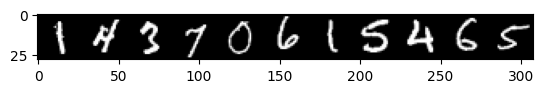

In [126]:
plt.imshow(imgProcess,cmap='gray')
plt.show()
plt.close(fig)

In [130]:
# 需要按照x的大小来排序，避免数字乱序：
def sort_number(Boarder):
    # x_list = []
    # for (imgRes, x, y, s) in Borderlist:
    #     x_list.append(x)
    Boarder = sorted(Boarder,key=lambda x:x[1])
    return Boarder

0


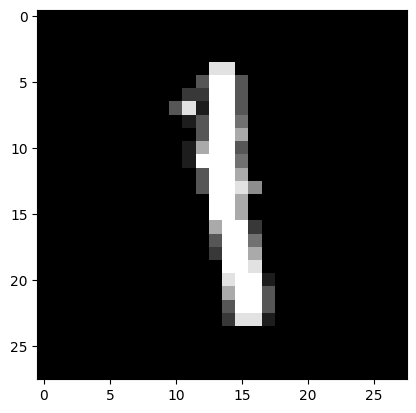

29


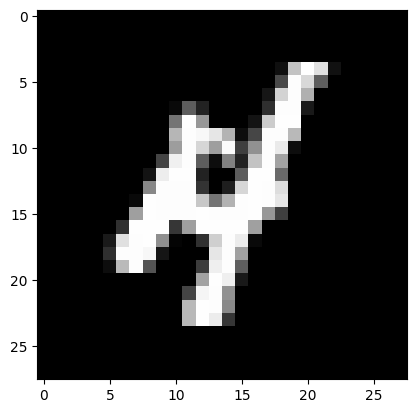

56


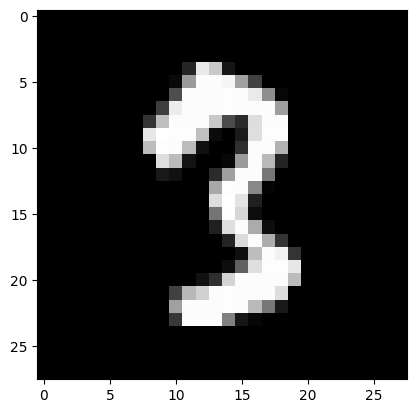

85


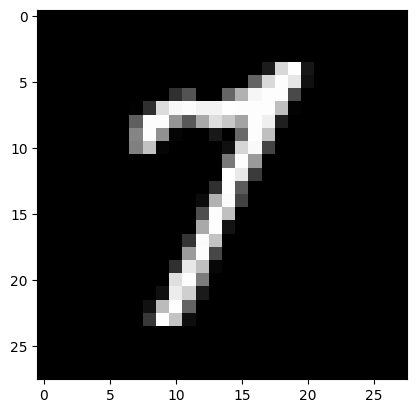

112


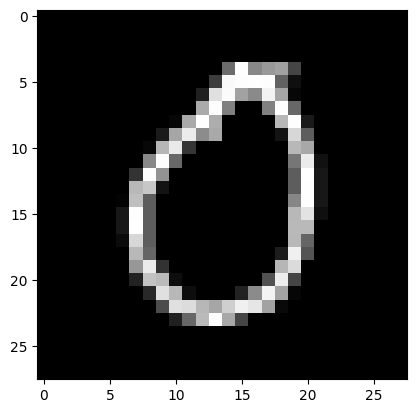

142


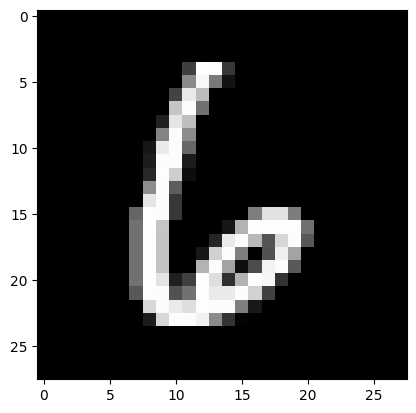

170


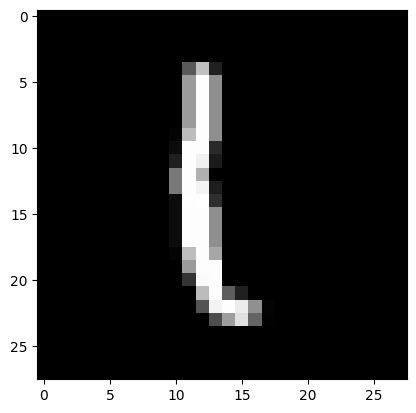

197


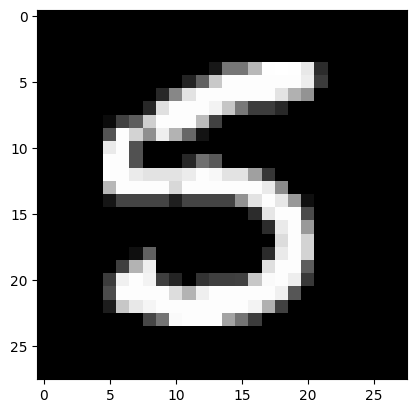

224


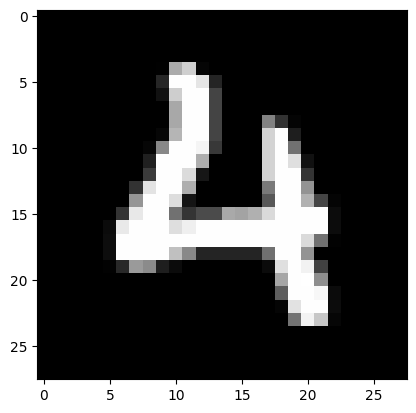

253


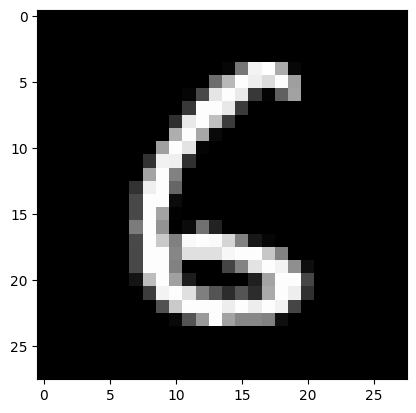

282


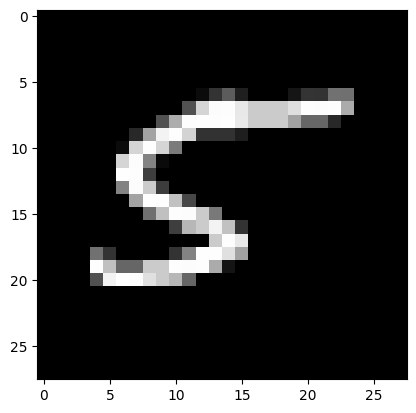

In [134]:
Boarderlist_s = sort_number(Borderlist)
for (imgRes, x, y, s) in Boarderlist_s:
    print(x)
    fig = plt.figure()
    plt.imshow(imgRes,cmap='gray')
    plt.show()
    plt.close(fig)

In [149]:
resnet18_trans = models.ResNet18_Weights.DEFAULT.transforms()
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Lambda(lambda x:x.repeat(3,1,1)),
        resnet18_trans]
)
test_data = []
for (ImgRes,_,_,_) in Boarderlist_s:
    # ImgRes = np.expand_dims(ImgRes,0)
    # print(ImgRes.shape)
    test_data.append(transform(ImgRes))

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


In [157]:
test_dataset = []
for i in range(len(test_data)):
    test_dataset.append((torch.Tensor(test_data[i]),target[0][i]))
test_dataset

[(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
  
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
  
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           

In [151]:
def predict(model,test_data):
    model = model.to(device)
    # predict:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_data):
            inputs,targets = data
            
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            
            _,predicted = torch.max(outputs.data,dim=1)
            total += inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
    acc = correct/total*100
    print("Acc in test dataset: {}%".format(acc))

In [ ]:
model_path = './weights/checkpoints/Resnet18_ft.pth'
model_ft = torch.load(model_path)
predict(model_ft,test_dataset)